# FinBERT Example Notebook

This notebooks shows how to train and use the FinBERT pre-trained language model for financial sentiment analysis.

## Modules 

In [1]:
from pathlib import Path
import shutil
import os
import logging
import sys
import pandas as pd
sys.path.append('..')

from textblob import TextBlob
from pprint import pprint
from sklearn.metrics import classification_report

from transformers import AutoModelForSequenceClassification

from finbert.finbert import *
import finbert.utils as tools

%load_ext autoreload
%autoreload 2

project_dir = Path.cwd().parent
pd.set_option('max_colwidth', 1)

/Users/pasindusankalpa/Documents/finBERT/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.ERROR)

## Prepare the model

### Setting path variables:
1. `lm_path`: the path for the pre-trained language model (If vanilla Bert is used then no need to set this one).
2. `cl_path`: the path where the classification model is saved.
3. `cl_data_path`: the path of the directory that contains the data files of `train.csv`, `validation.csv`, `test.csv`.
---

In the initialization of `bertmodel`, we can either use the original pre-trained weights from Google by giving `bm = 'bert-base-uncased`, or our further pre-trained language model by `bm = lm_path`


---
All of the configurations with the model is controlled with the `config` variable. 

# Finetune With All agree dataset 

In [18]:
cl_data_path = project_dir/'data'/'sentiment_data'/'All_ageed'
cl_path = project_dir/'models'/'classifier_model'/'finbert-sentiment'/'all_agree_data_augmented_fintuned'

In [6]:
# combine train data set
from numpy import negative


train_df_before =  pd.read_csv(
    cl_data_path/'train.csv' , sep="\t",
                index_col=False, 
)
train_df_before.head()

count_df = train_df_before['label'].value_counts().to_dict()
count_df

negative_augmented = pd.read_csv(
    cl_data_path/'augmented_negative_df.csv',
    
)


positive_augmented = pd.read_csv(
    cl_data_path/'augmented_positive_df.csv',
   
)

train_df_after = pd.concat([train_df_before, negative_augmented, positive_augmented])


#save the combined data
train_df_after.to_csv(cl_data_path/'train.csv', index=False, sep="\t", encoding="utf-8")

print(train_df_after.shape)
print(train_df_before.shape)

(2256, 2)
(1629, 2)


###  Configuring training parameters

You can find the explanations of the training parameters in the class docsctrings. 

In [7]:
# Clean the cl_path
try:
    shutil.rmtree(cl_path) 
except:
    pass

bertmodel = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert",cache_dir=None, num_labels=3)


config = Config(   data_dir=cl_data_path,
                   bert_model=bertmodel,
                   num_train_epochs=6,
                   model_dir=cl_path,
                   max_seq_length = 64,
                   train_batch_size = 64,
                   learning_rate = 2e-5,
                   output_mode='classification',
                   warm_up_proportion=0.2,
                   local_rank=-1,
                   discriminate=True,
                   gradual_unfreeze=True)

`finbert` is our main class that encapsulates all the functionality. The list of class labels should be given in the prepare_model method call with label_list parameter.

In [8]:
finbert = FinBert(config)
finbert.base_model = 'bert-base-uncased'
finbert.config.discriminate=True
finbert.config.gradual_unfreeze=True

In [9]:
finbert.prepare_model(label_list=['positive','negative','neutral'])

10/04/2025 16:56:06 - INFO - finbert.finbert -   device: cpu n_gpu: 0, distributed training: False, 16-bits training: False


## Fine-tune the model

In [10]:
# Get the training examples
train_data = finbert.get_data('train')

In [11]:
model = finbert.create_the_model()

### [Optional] Fine-tune only a subset of the model
The variable `freeze` determines the last layer (out of 12) to be freezed. You can skip this part if you want to fine-tune the whole model.

<span style="color:red">Important: </span>
Execute this step if you want a shorter training time in the expense of accuracy.

In [12]:
# This is for fine-tuning a subset of the model.

freeze = 6

for param in model.bert.embeddings.parameters():
    param.requires_grad = False
    
for i in range(freeze):
    for param in model.bert.encoder.layer[i].parameters():
        param.requires_grad = False

### Training

In [13]:
trained_model = finbert.train(train_examples = train_data, model = model)

10/04/2025 16:56:16 - INFO - finbert.utils -   *** Example ***
10/04/2025 16:56:16 - INFO - finbert.utils -   guid: train-1
10/04/2025 16:56:16 - INFO - finbert.utils -   tokens: [CLS] 2009 3 february 2010 - finland - based steel maker ra ##uta ##ru ##uk ##ki rt ##rks ) , or ru ##uk ##ki , said today it slipped to a larger - than - expected pre ##ta ##x loss of eu ##r ##46 ##m in the fourth quarter of 2009 from a year - earlier profit of eu ##r ##45 ##m . [SEP]
10/04/2025 16:56:16 - INFO - finbert.utils -   input_ids: 101 2268 1017 2337 2230 1011 6435 1011 2241 3886 9338 10958 13210 6820 6968 3211 19387 19987 1007 1010 2030 21766 6968 3211 1010 2056 2651 2009 5707 2000 1037 3469 1011 2084 1011 3517 3653 2696 2595 3279 1997 7327 2099 21472 2213 1999 1996 2959 4284 1997 2268 2013 1037 2095 1011 3041 5618 1997 7327 2099 19961 2213 1012 102
10/04/2025 16:56:16 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

Validation losses: [0.12302194784084956]
No best model found


Iteration: 100%|██████████| 36/36 [01:04<00:00,  1.80s/it]
10/04/2025 16:58:12 - INFO - finbert.utils -   *** Example ***
10/04/2025 16:58:12 - INFO - finbert.utils -   guid: validation-1
10/04/2025 16:58:12 - INFO - finbert.utils -   tokens: [CLS] for the new shares sub ##scribe ##d with stock options all shareholder rights commence from the date on which they are entered into the trade register . [SEP]
10/04/2025 16:58:12 - INFO - finbert.utils -   input_ids: 101 2005 1996 2047 6661 4942 29234 2094 2007 4518 7047 2035 18668 2916 22825 2013 1996 3058 2006 2029 2027 2024 3133 2046 1996 3119 4236 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
10/04/2025 16:58:12 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
10/04/2025 16:58:12 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

Validation losses: [0.12302194784084956, 0.10393384844064713]


Iteration: 100%|██████████| 36/36 [01:23<00:00,  2.32s/it]
10/04/2025 16:59:39 - INFO - finbert.utils -   *** Example ***
10/04/2025 16:59:39 - INFO - finbert.utils -   guid: validation-1
10/04/2025 16:59:39 - INFO - finbert.utils -   tokens: [CLS] for the new shares sub ##scribe ##d with stock options all shareholder rights commence from the date on which they are entered into the trade register . [SEP]
10/04/2025 16:59:39 - INFO - finbert.utils -   input_ids: 101 2005 1996 2047 6661 4942 29234 2094 2007 4518 7047 2035 18668 2916 22825 2013 1996 3058 2006 2029 2027 2024 3133 2046 1996 3119 4236 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
10/04/2025 16:59:39 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
10/04/2025 16:59:39 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

Validation losses: [0.12302194784084956, 0.10393384844064713, 0.09169804056485494]


Iteration: 100%|██████████| 36/36 [01:42<00:00,  2.86s/it]
10/04/2025 17:01:24 - INFO - finbert.utils -   *** Example ***
10/04/2025 17:01:24 - INFO - finbert.utils -   guid: validation-1
10/04/2025 17:01:24 - INFO - finbert.utils -   tokens: [CLS] for the new shares sub ##scribe ##d with stock options all shareholder rights commence from the date on which they are entered into the trade register . [SEP]
10/04/2025 17:01:24 - INFO - finbert.utils -   input_ids: 101 2005 1996 2047 6661 4942 29234 2094 2007 4518 7047 2035 18668 2916 22825 2013 1996 3058 2006 2029 2027 2024 3133 2046 1996 3119 4236 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
10/04/2025 17:01:24 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
10/04/2025 17:01:24 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

Validation losses: [0.12302194784084956, 0.10393384844064713, 0.09169804056485494, 0.09431273241837819]


Iteration: 100%|██████████| 36/36 [01:55<00:00,  3.20s/it]
10/04/2025 17:03:22 - INFO - finbert.utils -   *** Example ***
10/04/2025 17:03:22 - INFO - finbert.utils -   guid: validation-1
10/04/2025 17:03:22 - INFO - finbert.utils -   tokens: [CLS] for the new shares sub ##scribe ##d with stock options all shareholder rights commence from the date on which they are entered into the trade register . [SEP]
10/04/2025 17:03:22 - INFO - finbert.utils -   input_ids: 101 2005 1996 2047 6661 4942 29234 2094 2007 4518 7047 2035 18668 2916 22825 2013 1996 3058 2006 2029 2027 2024 3133 2046 1996 3119 4236 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
10/04/2025 17:03:22 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
10/04/2025 17:03:22 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

Validation losses: [0.12302194784084956, 0.10393384844064713, 0.09169804056485494, 0.09431273241837819, 0.0886783121774594]


Iteration: 100%|██████████| 36/36 [01:56<00:00,  3.25s/it]
10/04/2025 17:05:23 - INFO - finbert.utils -   *** Example ***
10/04/2025 17:05:23 - INFO - finbert.utils -   guid: validation-1
10/04/2025 17:05:23 - INFO - finbert.utils -   tokens: [CLS] for the new shares sub ##scribe ##d with stock options all shareholder rights commence from the date on which they are entered into the trade register . [SEP]
10/04/2025 17:05:23 - INFO - finbert.utils -   input_ids: 101 2005 1996 2047 6661 4942 29234 2094 2007 4518 7047 2035 18668 2916 22825 2013 1996 3058 2006 2029 2027 2024 3133 2046 1996 3119 4236 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
10/04/2025 17:05:23 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
10/04/2025 17:05:23 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

Validation losses: [0.12302194784084956, 0.10393384844064713, 0.09169804056485494, 0.09431273241837819, 0.0886783121774594, 0.09065546592076619]


## Test the model

`bert.evaluate` outputs the DataFrame, where true labels and logit values for each example is given

### with all agree test data set

#### trained model

In [14]:
test_data = finbert.get_data('test')

In [15]:
results = finbert.evaluate(examples=test_data, model=trained_model)

10/04/2025 17:22:42 - INFO - finbert.utils -   *** Example ***
10/04/2025 17:22:42 - INFO - finbert.utils -   guid: test-1
10/04/2025 17:22:42 - INFO - finbert.utils -   tokens: [CLS] card ##ona slowed her vehicle , turned around and returned to the intersection , where she called 911 . [SEP]
10/04/2025 17:22:42 - INFO - finbert.utils -   input_ids: 101 4003 7856 9784 2014 4316 1010 2357 2105 1998 2513 2000 1996 6840 1010 2073 2016 2170 19989 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
10/04/2025 17:22:42 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
10/04/2025 17:22:42 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
10/04/2025 17:22:42 - INFO - finbert.utils -   label: neutral (id = 2)
10/04

### Prepare the classification report

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def report(df, cols=['label','prediction','logits']):
    #print('Validation loss:{0:.2f}'.format(metrics['best_validation_loss']))
    cs = CrossEntropyLoss(weight=finbert.class_weights)
    loss = cs(torch.tensor(list(df[cols[2]])),torch.tensor(list(df[cols[0]])))
    print("Loss:{0:.2f}".format(loss))
    print("Accuracy:{0:.2f}".format((df[cols[0]] == df[cols[1]]).sum() / df.shape[0]) )
    print("\nClassification Report:")
    report, y_true, y_pred = classification_report(df[cols[0]], df[cols[1]])
    print(report)
    plt.figure(figsize=(10, 10))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d')
    plt.show()


In [17]:
results['prediction'] = results.predictions.apply(lambda x: np.argmax(x,axis=0))

/var/folders/bt/47lhlkx11kd7rvpdmc4zmjh00000gn/T/ipykernel_33956/2059374156.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  loss = cs(torch.tensor(list(df[cols[2]])),torch.tensor(list(df[cols[0]])))


Loss:0.05
Accuracy:0.99

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       117
           1       0.98      0.95      0.97        60
           2       1.00      0.99      0.99       276

    accuracy                           0.99       453
   macro avg       0.98      0.98      0.98       453
weighted avg       0.99      0.99      0.99       453



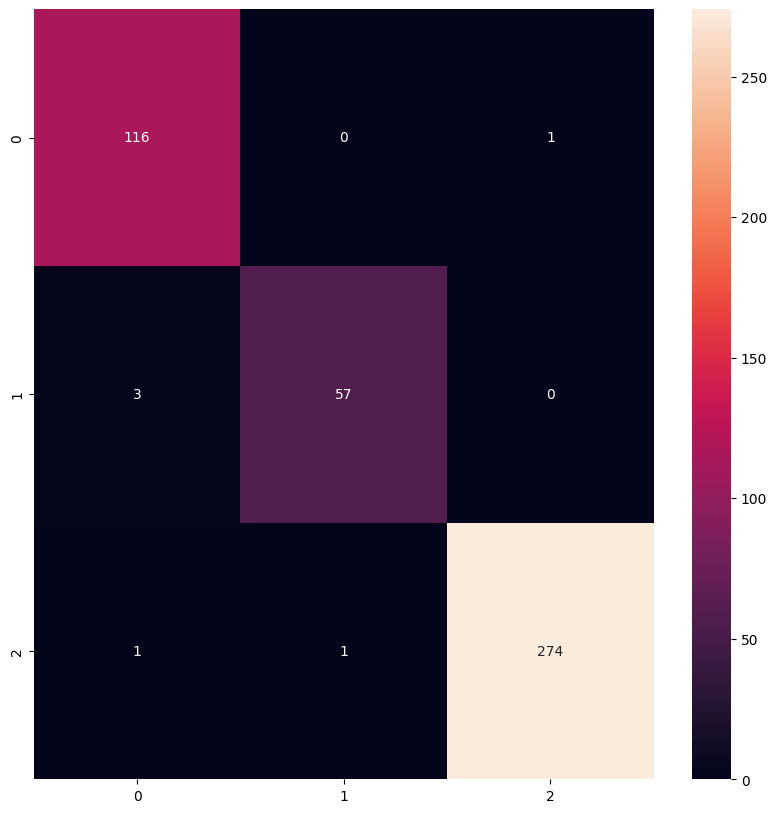

In [16]:
report(results,cols=['labels','prediction','predictions'])



##### Without finetuning FinBert (Existing FinBert)

In [39]:
base_model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert", cache_dir=None, num_labels=3)


In [40]:
test_data = finbert.get_data('test')

In [41]:
results = finbert.evaluate(examples=test_data, model=base_model)

10/04/2025 17:39:18 - INFO - finbert.utils -   *** Example ***
10/04/2025 17:39:18 - INFO - finbert.utils -   guid: test-1
10/04/2025 17:39:18 - INFO - finbert.utils -   tokens: [CLS] card ##ona slowed her vehicle , turned around and returned to the intersection , where she called 911 . [SEP]
10/04/2025 17:39:18 - INFO - finbert.utils -   input_ids: 101 4003 7856 9784 2014 4316 1010 2357 2105 1998 2513 2000 1996 6840 1010 2073 2016 2170 19989 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
10/04/2025 17:39:18 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
10/04/2025 17:39:18 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
10/04/2025 17:39:18 - INFO - finbert.utils -   label: neutral (id = 2)


10/04/2025 17:39:18 - INFO - finbert.finbert -   ***** Loading data *****
10/04/2025 17:39:18 - INFO - finbert.finbert -     Num examples = 453
10/04/2025 17:39:18 - INFO - finbert.finbert -     Batch size = 64
10/04/2025 17:39:18 - INFO - finbert.finbert -     Num steps = 42
10/04/2025 17:39:18 - INFO - finbert.finbert -   ***** Running evaluation ***** 
10/04/2025 17:39:18 - INFO - finbert.finbert -     Num examples = 453
10/04/2025 17:39:18 - INFO - finbert.finbert -     Batch size = 32
Testing: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Accuracy:0.98

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       117
           1       0.94      1.00      0.97        60
           2       1.00      0.97      0.99       276

    accuracy                           0.98       453
   macro avg       0.97      0.99      0.98       453
weighted avg       0.98      0.98      0.98       453



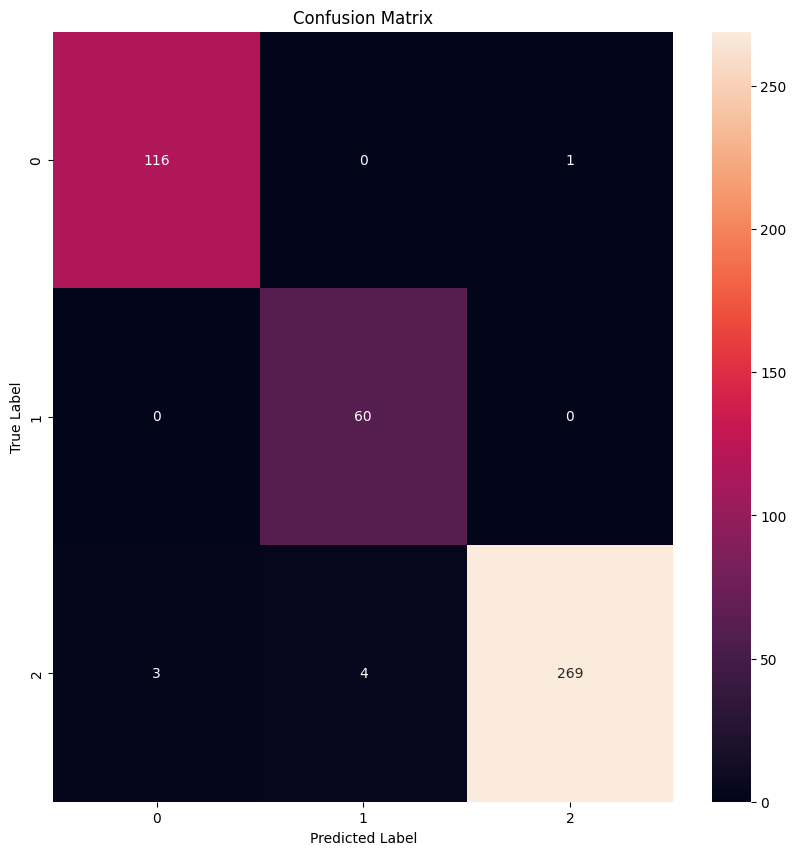

In [44]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def report(df, cols=['label','prediction','logits']):
    #print('Validation loss:{0:.2f}'.format(metrics['best_validation_loss']))
    # cs = CrossEntropyLoss(weight=model.class_weights)
    # print("Loss:{0:.2f}".format(loss))
    print("Accuracy:{0:.2f}".format((df[cols[0]] == df[cols[1]]).sum() / df.shape[0]) )
    print("\nClassification Report:")
    y_true = df[cols[0]]
    y_pred = df[cols[1]]
    print(classification_report(y_true, y_pred))
    plt.figure(figsize=(10, 10))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
results['prediction'] = results.predictions.apply(lambda x: np.argmax(x,axis=0))
report(results,cols=['labels','prediction','predictions'])


### 75 Agree test dataset

In [58]:
cl_data_path = project_dir/'data'/'sentiment_data'/'75_agree'

In [61]:

config = Config(   data_dir=cl_data_path,
                   bert_model=bertmodel,
                   num_train_epochs=6,
                   model_dir=cl_path,
                   max_seq_length = 64,
                   train_batch_size = 64,
                   learning_rate = 2e-5,
                   output_mode='classification',
                   warm_up_proportion=0.2,
                   local_rank=-1,
                   discriminate=True,
                   gradual_unfreeze=True)

finbert = FinBert(config)
finbert.base_model = 'bert-base-uncased'
finbert.config.discriminate=True
finbert.config.gradual_unfreeze=True

finbert.prepare_model(label_list=['positive','negative','neutral'])

10/04/2025 18:13:13 - INFO - finbert.finbert -   device: cpu n_gpu: 0, distributed training: False, 16-bits training: False


##### fine tuned model

10/04/2025 18:13:17 - INFO - finbert.utils -   *** Example ***
10/04/2025 18:13:17 - INFO - finbert.utils -   guid: test-1
10/04/2025 18:13:17 - INFO - finbert.utils -   tokens: [CLS] it is expected to be completed by the end of 2007 . [SEP]
10/04/2025 18:13:17 - INFO - finbert.utils -   input_ids: 101 2009 2003 3517 2000 2022 2949 2011 1996 2203 1997 2289 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
10/04/2025 18:13:17 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
10/04/2025 18:13:17 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
10/04/2025 18:13:17 - INFO - finbert.utils -   label: neutral (id = 2)


10/04/2025 18:13:17 - INFO - finbert.finbert -   ***** Loading data *****
10/04/2025 18:13:17 - INFO - finbert.finbert -     Num examples = 691
10/04/2025 18:13:17 - INFO - finbert.finbert -     Batch size = 64
10/04/2025 18:13:17 - INFO - finbert.finbert -     Num steps = 60
10/04/2025 18:13:17 - INFO - finbert.finbert -   ***** Running evaluation ***** 
10/04/2025 18:13:17 - INFO - finbert.finbert -     Num examples = 691
10/04/2025 18:13:17 - INFO - finbert.finbert -     Batch size = 32
Testing: 100%|██████████| 11/11 [00:08<00:00,  1.25it/s]

Accuracy:0.97

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       200
           1       0.94      0.96      0.95        83
           2       0.99      0.97      0.98       408

    accuracy                           0.97       691
   macro avg       0.96      0.97      0.97       691
weighted avg       0.97      0.97      0.97       691



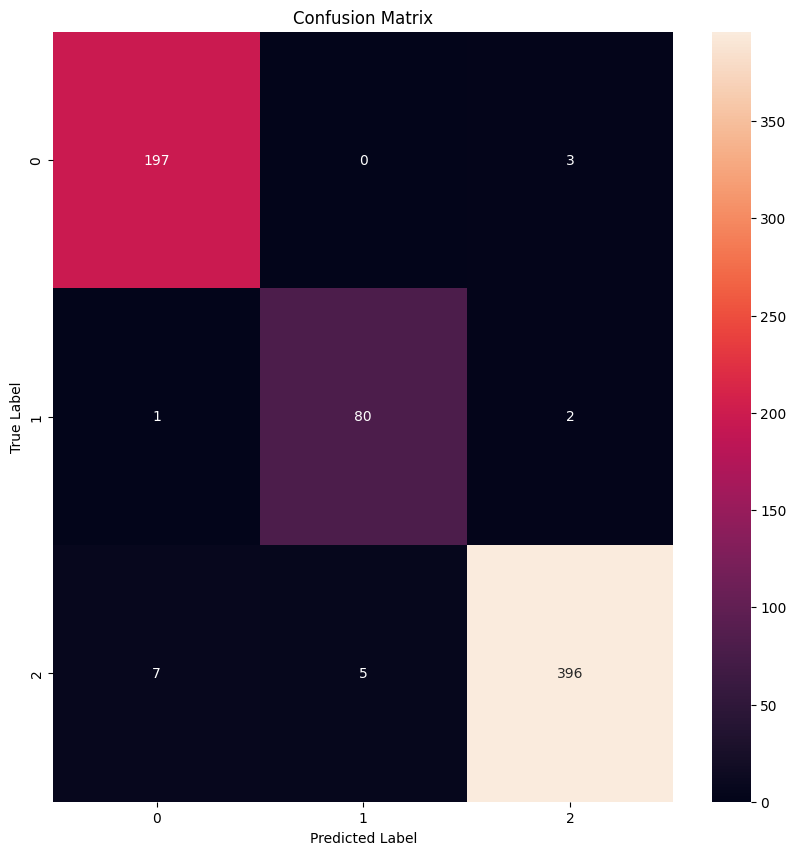

In [62]:
test_data = finbert.get_data('test')
results = finbert.evaluate(examples=test_data, model=trained_model)



import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def report(df, cols=['label','prediction','logits']):
    #print('Validation loss:{0:.2f}'.format(metrics['best_validation_loss']))
    # cs = CrossEntropyLoss(weight=model.class_weights)
    # print("Loss:{0:.2f}".format(loss))
    print("Accuracy:{0:.2f}".format((df[cols[0]] == df[cols[1]]).sum() / df.shape[0]) )
    print("\nClassification Report:")
    y_true = df[cols[0]]
    y_pred = df[cols[1]]
    print(classification_report(y_true, y_pred))
    plt.figure(figsize=(10, 10))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    

    
results['prediction'] = results.predictions.apply(lambda x: np.argmax(x,axis=0))

report(results,cols=['labels','prediction','predictions'])






In [54]:
### without finetuning FinBert (Existing FinBert)

10/04/2025 18:13:48 - INFO - finbert.utils -   *** Example ***
10/04/2025 18:13:48 - INFO - finbert.utils -   guid: test-1
10/04/2025 18:13:48 - INFO - finbert.utils -   tokens: [CLS] it is expected to be completed by the end of 2007 . [SEP]
10/04/2025 18:13:48 - INFO - finbert.utils -   input_ids: 101 2009 2003 3517 2000 2022 2949 2011 1996 2203 1997 2289 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
10/04/2025 18:13:48 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
10/04/2025 18:13:48 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
10/04/2025 18:13:48 - INFO - finbert.utils -   label: neutral (id = 2)
10/04/2025 18:13:48 - INFO - finbert.finbert -   ***** Loading data *****
10/04

Accuracy:0.95

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       200
           1       0.83      0.98      0.90        83
           2       0.99      0.93      0.96       408

    accuracy                           0.95       691
   macro avg       0.91      0.96      0.93       691
weighted avg       0.95      0.95      0.95       691



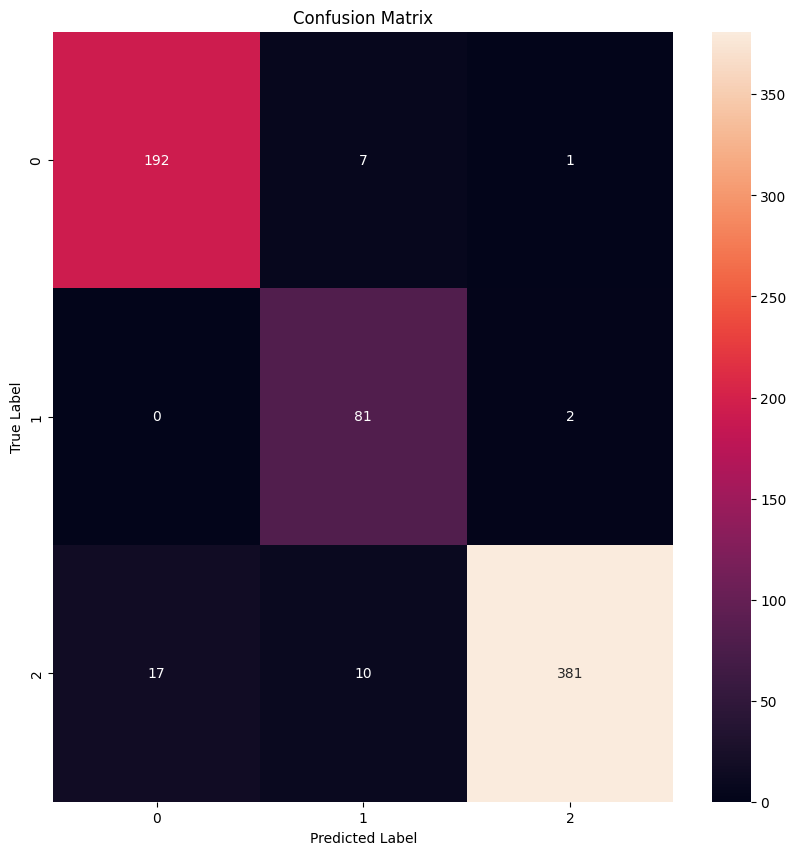

In [63]:
test_data = finbert.get_data('test')
results = finbert.evaluate(examples=test_data, model=base_model)



import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def report(df, cols=['label','prediction','logits']):
    #print('Validation loss:{0:.2f}'.format(metrics['best_validation_loss']))
    # cs = CrossEntropyLoss(weight=model.class_weights)
    # print("Loss:{0:.2f}".format(loss))
    print("Accuracy:{0:.2f}".format((df[cols[0]] == df[cols[1]]).sum() / df.shape[0]) )
    print("\nClassification Report:")
    y_true = df[cols[0]]
    y_pred = df[cols[1]]
    print(classification_report(y_true, y_pred))
    plt.figure(figsize=(10, 10))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    

    
results['prediction'] = results.predictions.apply(lambda x: np.argmax(x,axis=0))

report(results,cols=['labels','prediction','predictions'])






### 50_agree test dataset

In [64]:
cl_data_path = project_dir/'data'/'sentiment_data'/'50_agree'

config = Config(   data_dir=cl_data_path,
                   bert_model=bertmodel,
                   num_train_epochs=6,
                   model_dir=cl_path,
                   max_seq_length = 64,
                   train_batch_size = 64,
                   learning_rate = 2e-5,
                   output_mode='classification',
                   warm_up_proportion=0.2,
                   local_rank=-1,
                   discriminate=True,
                   gradual_unfreeze=True)

finbert = FinBert(config)
finbert.base_model = 'bert-base-uncased'
finbert.config.discriminate=True
finbert.config.gradual_unfreeze=True

finbert.prepare_model(label_list=['positive','negative','neutral'])

10/04/2025 18:14:07 - INFO - finbert.finbert -   device: cpu n_gpu: 0, distributed training: False, 16-bits training: False


10/04/2025 18:14:11 - INFO - finbert.utils -   *** Example ***
10/04/2025 18:14:11 - INFO - finbert.utils -   guid: test-1
10/04/2025 18:14:11 - INFO - finbert.utils -   tokens: [CLS] the bristol port company has sealed a one million pound contract with cooper specialised handling to supply it with four 45 - ton ##ne , custom ##ised reach stack ##ers from ko ##ne ##cr ##ane ##s . [SEP]
10/04/2025 18:14:11 - INFO - finbert.utils -   input_ids: 101 1996 7067 3417 2194 2038 10203 1037 2028 2454 9044 3206 2007 6201 17009 8304 2000 4425 2009 2007 2176 3429 1011 10228 2638 1010 7661 5084 3362 9991 2545 2013 12849 2638 26775 7231 2015 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
10/04/2025 18:14:11 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
10/04/2025 18:14:11 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

10/04/2025 18:14:11 - INFO - finbert.finbert -   ***** Loading data *****
10/04/2025 18:14:11 - INFO - finbert.finbert -     Num examples = 970
10/04/2025 18:14:11 - INFO - finbert.finbert -     Batch size = 64
10/04/2025 18:14:11 - INFO - finbert.finbert -     Num steps = 90
10/04/2025 18:14:11 - INFO - finbert.finbert -   ***** Running evaluation ***** 
10/04/2025 18:14:11 - INFO - finbert.finbert -     Num examples = 970
10/04/2025 18:14:11 - INFO - finbert.finbert -     Batch size = 32
Testing: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s]

Accuracy:0.86

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       267
           1       0.86      0.87      0.86       128
           2       0.89      0.88      0.89       575

    accuracy                           0.86       970
   macro avg       0.85      0.86      0.85       970
weighted avg       0.86      0.86      0.86       970



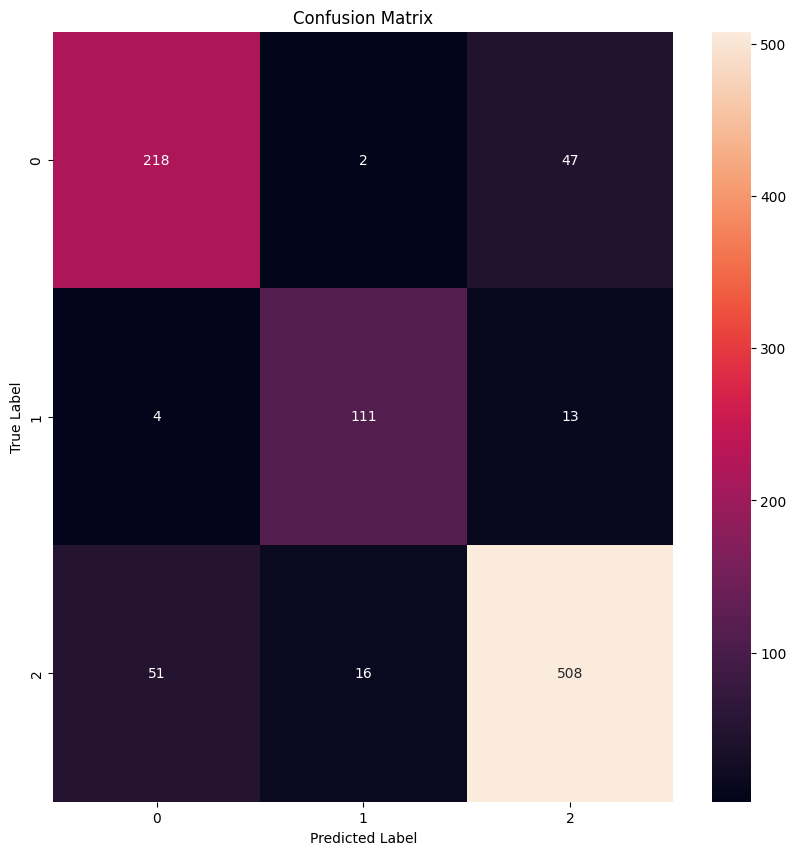

In [65]:
test_data = finbert.get_data('test')
results = finbert.evaluate(examples=test_data, model=trained_model)



import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def report(df, cols=['label','prediction','logits']):
    #print('Validation loss:{0:.2f}'.format(metrics['best_validation_loss']))
    # cs = CrossEntropyLoss(weight=model.class_weights)
    # print("Loss:{0:.2f}".format(loss))
    print("Accuracy:{0:.2f}".format((df[cols[0]] == df[cols[1]]).sum() / df.shape[0]) )
    print("\nClassification Report:")
    y_true = df[cols[0]]
    y_pred = df[cols[1]]
    print(classification_report(y_true, y_pred))
    plt.figure(figsize=(10, 10))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    

    
results['prediction'] = results.predictions.apply(lambda x: np.argmax(x,axis=0))

report(results,cols=['labels','prediction','predictions'])






10/04/2025 18:14:31 - INFO - finbert.utils -   *** Example ***
10/04/2025 18:14:31 - INFO - finbert.utils -   guid: test-1
10/04/2025 18:14:31 - INFO - finbert.utils -   tokens: [CLS] the bristol port company has sealed a one million pound contract with cooper specialised handling to supply it with four 45 - ton ##ne , custom ##ised reach stack ##ers from ko ##ne ##cr ##ane ##s . [SEP]
10/04/2025 18:14:31 - INFO - finbert.utils -   input_ids: 101 1996 7067 3417 2194 2038 10203 1037 2028 2454 9044 3206 2007 6201 17009 8304 2000 4425 2009 2007 2176 3429 1011 10228 2638 1010 7661 5084 3362 9991 2545 2013 12849 2638 26775 7231 2015 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
10/04/2025 18:14:31 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
10/04/2025 18:14:31 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

10/04/2025 18:14:32 - INFO - finbert.finbert -   ***** Loading data *****
10/04/2025 18:14:32 - INFO - finbert.finbert -     Num examples = 970
10/04/2025 18:14:32 - INFO - finbert.finbert -     Batch size = 64
10/04/2025 18:14:32 - INFO - finbert.finbert -     Num steps = 90
10/04/2025 18:14:32 - INFO - finbert.finbert -   ***** Running evaluation ***** 
10/04/2025 18:14:32 - INFO - finbert.finbert -     Num examples = 970
10/04/2025 18:14:32 - INFO - finbert.finbert -     Batch size = 32
Testing: 100%|██████████| 16/16 [00:12<00:00,  1.32it/s]

Accuracy:0.84

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.86      0.81       267
           1       0.74      0.95      0.83       128
           2       0.92      0.81      0.86       575

    accuracy                           0.84       970
   macro avg       0.81      0.87      0.83       970
weighted avg       0.85      0.84      0.84       970



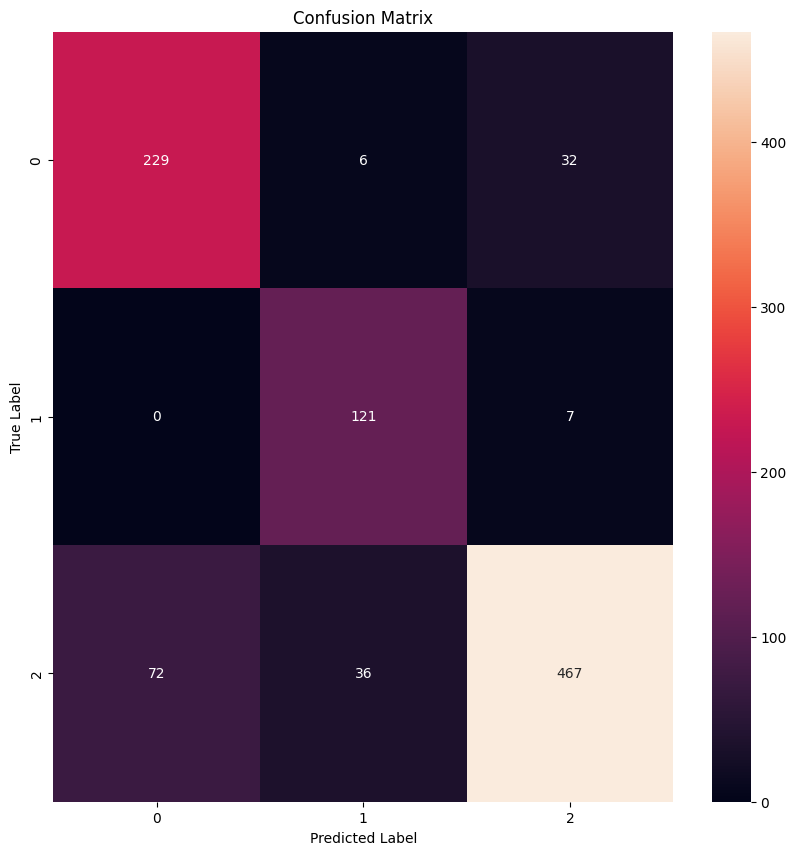

In [66]:
test_data = finbert.get_data('test')
results = finbert.evaluate(examples=test_data, model=base_model)



import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def report(df, cols=['label','prediction','logits']):
    #print('Validation loss:{0:.2f}'.format(metrics['best_validation_loss']))
    # cs = CrossEntropyLoss(weight=model.class_weights)
    # print("Loss:{0:.2f}".format(loss))
    print("Accuracy:{0:.2f}".format((df[cols[0]] == df[cols[1]]).sum() / df.shape[0]) )
    print("\nClassification Report:")
    y_true = df[cols[0]]
    y_pred = df[cols[1]]
    print(classification_report(y_true, y_pred))
    plt.figure(figsize=(10, 10))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    

    
results['prediction'] = results.predictions.apply(lambda x: np.argmax(x,axis=0))

report(results,cols=['labels','prediction','predictions'])






### 66 agree test dataset

In [67]:
cl_data_path = project_dir/'data'/'sentiment_data'/'66_agree'

config = Config(   data_dir=cl_data_path,
                   bert_model=bertmodel,
                   num_train_epochs=6,
                   model_dir=cl_path,
                   max_seq_length = 64,
                   train_batch_size = 64,
                   learning_rate = 2e-5,
                   output_mode='classification',
                   warm_up_proportion=0.2,
                   local_rank=-1,
                   discriminate=True,
                   gradual_unfreeze=True)

finbert = FinBert(config)
finbert.base_model = 'bert-base-uncased'
finbert.config.discriminate=True
finbert.config.gradual_unfreeze=True

finbert.prepare_model(label_list=['positive','negative','neutral'])

10/04/2025 18:20:25 - INFO - finbert.finbert -   device: cpu n_gpu: 0, distributed training: False, 16-bits training: False


10/04/2025 18:20:44 - INFO - finbert.utils -   *** Example ***
10/04/2025 18:20:44 - INFO - finbert.utils -   guid: test-1
10/04/2025 18:20:44 - INFO - finbert.utils -   tokens: [CLS] the purchase price will be paid in cash upon the closure of the transaction , scheduled for april 1 , 2009 . [SEP]
10/04/2025 18:20:44 - INFO - finbert.utils -   input_ids: 101 1996 5309 3976 2097 2022 3825 1999 5356 2588 1996 8503 1997 1996 12598 1010 5115 2005 2258 1015 1010 2268 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
10/04/2025 18:20:44 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
10/04/2025 18:20:44 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
10/04/2025 18:20:44 - INFO - finbert.utils -   label: neutral 

Accuracy:0.94

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       243
           1       0.95      0.97      0.96        95
           2       0.96      0.95      0.95       506

    accuracy                           0.94       844
   macro avg       0.94      0.95      0.94       844
weighted avg       0.94      0.94      0.94       844



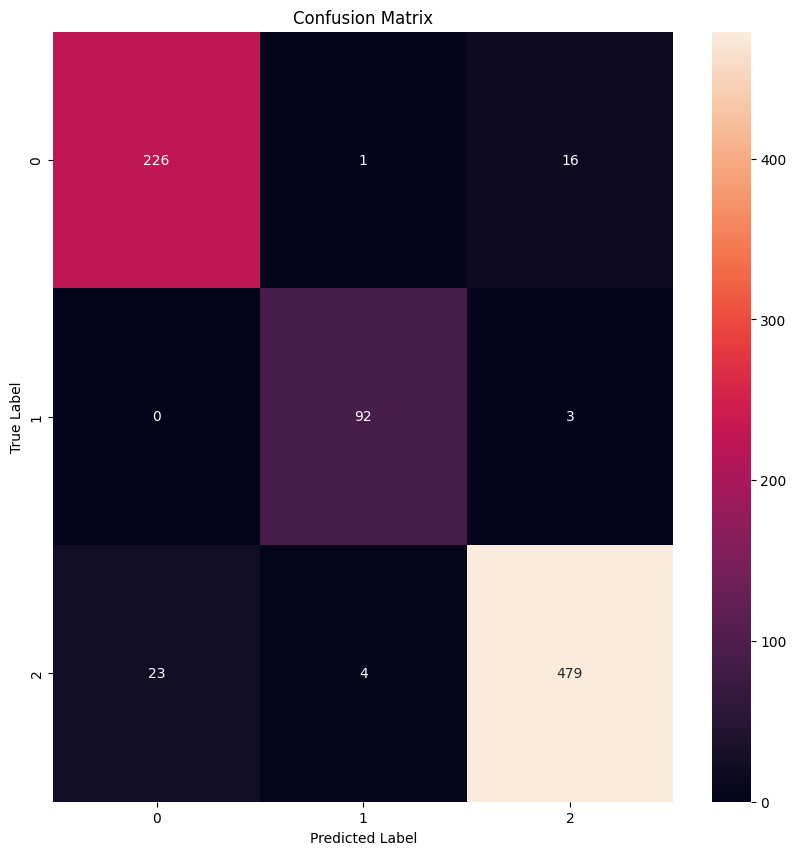

In [68]:
test_data = finbert.get_data('test')
results = finbert.evaluate(examples=test_data, model=trained_model)



import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def report(df, cols=['label','prediction','logits']):
    #print('Validation loss:{0:.2f}'.format(metrics['best_validation_loss']))
    # cs = CrossEntropyLoss(weight=model.class_weights)
    # print("Loss:{0:.2f}".format(loss))
    print("Accuracy:{0:.2f}".format((df[cols[0]] == df[cols[1]]).sum() / df.shape[0]) )
    print("\nClassification Report:")
    y_true = df[cols[0]]
    y_pred = df[cols[1]]
    print(classification_report(y_true, y_pred))
    plt.figure(figsize=(10, 10))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    

    
results['prediction'] = results.predictions.apply(lambda x: np.argmax(x,axis=0))

report(results,cols=['labels','prediction','predictions'])






10/04/2025 18:21:00 - INFO - finbert.utils -   *** Example ***
10/04/2025 18:21:00 - INFO - finbert.utils -   guid: test-1
10/04/2025 18:21:00 - INFO - finbert.utils -   tokens: [CLS] the purchase price will be paid in cash upon the closure of the transaction , scheduled for april 1 , 2009 . [SEP]
10/04/2025 18:21:00 - INFO - finbert.utils -   input_ids: 101 1996 5309 3976 2097 2022 3825 1999 5356 2588 1996 8503 1997 1996 12598 1010 5115 2005 2258 1015 1010 2268 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
10/04/2025 18:21:00 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
10/04/2025 18:21:00 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
10/04/2025 18:21:00 - INFO - finbert.utils -   label: neutral 

Accuracy:0.92

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       243
           1       0.82      1.00      0.90        95
           2       0.98      0.89      0.93       506

    accuracy                           0.92       844
   macro avg       0.88      0.95      0.91       844
weighted avg       0.93      0.92      0.92       844



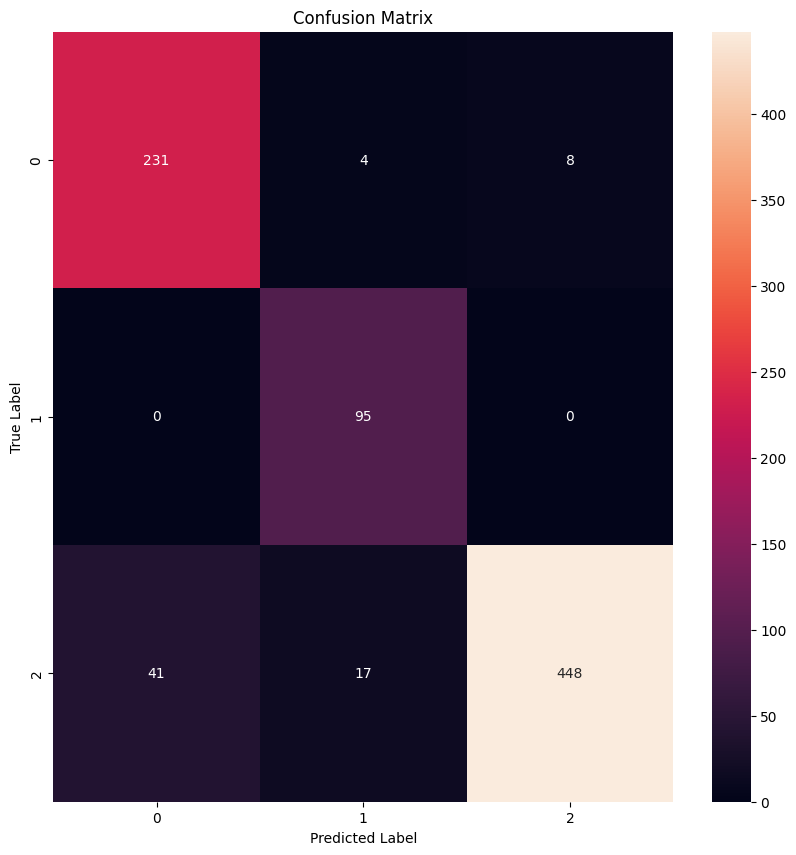

In [69]:
test_data = finbert.get_data('test')
results = finbert.evaluate(examples=test_data, model=base_model)



import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def report(df, cols=['label','prediction','logits']):
    #print('Validation loss:{0:.2f}'.format(metrics['best_validation_loss']))
    # cs = CrossEntropyLoss(weight=model.class_weights)
    # print("Loss:{0:.2f}".format(loss))
    print("Accuracy:{0:.2f}".format((df[cols[0]] == df[cols[1]]).sum() / df.shape[0]) )
    print("\nClassification Report:")
    y_true = df[cols[0]]
    y_pred = df[cols[1]]
    print(classification_report(y_true, y_pred))
    plt.figure(figsize=(10, 10))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    

    
results['prediction'] = results.predictions.apply(lambda x: np.argmax(x,axis=0))

report(results,cols=['labels','prediction','predictions'])




